In [57]:
import h5py
from New_grass import grassmannian_clustering_gruber2006
from tqdm import tqdm
import csv
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
import pickle

In [58]:
# Only dealing with data from sleep_run's for each subject
# All data has sample size 429
cluster_numbers = [2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15]
number_of_subjects = 33 
run_number = [2, 3, 4, 5] # sleep-run-numbers
all_data_matrices = {} # lib to hold all the sleep_stage data for each subject
valid_data_lib = {} # holds information about each subject and for what sleep stage runs we have data // valid_data_lib['01] - subject 1

for subject in range(1, number_of_subjects + 1):
    subject = str(subject).zfill(2) # fill 01, 02 and so on

    all_data_matrices[subject] = {}
    valid_data_lib[subject] = []

    for number in run_number:
        data_matrix = []
        with open(f"sleep_data/sleep_scores/sub-{subject}-sleep-stage.tsv", "r", newline="", encoding="utf-8") as tsv_file: # needs to do this for every number othervise it does not work
            tsv_reader = csv.reader(tsv_file, delimiter="\t")
            next(tsv_reader) # skip first row to remove column names
            for row in tsv_reader:
                if subject != "01":
                    if row[0] == f'task-sleep_run-{number}': 
                        data_matrix.append(row)
                else:
                    if row[1] == f'task-sleep_run-{number}': # We do this to handle the case where the first collumn is not 'task-sleep_run-x' as is the case for subject 1
                        data_matrix.append(row)   
            if len(data_matrix)>0:        
                all_data_matrices[subject][number] = data_matrix
                valid_data_lib[subject].append(number)

for number in run_number: # removing first collumn in data for subject "01" as it contains an extra collumn compared to the rest of the data
    try: 
        all_data_matrices["01"][number] = [row[1:] for row in all_data_matrices["01"][number]]
    except:
        continue

for subject in all_data_matrices: # removing subjects with no data for sleep stages at all
    numbers_to_remove = []
    for number in valid_data_lib[subject]: # removing sleep stages that contain a constant state 
        if len(np.unique([s[0] for s in np.array(all_data_matrices[subject][number])[:, 2]])) == 1:
            numbers_to_remove.append(number)
    for number in numbers_to_remove:
        valid_data_lib[subject].remove(number)
    if valid_data_lib[subject] == []:
        valid_data_lib.pop(subject)

# removing some subjects manually if they seem to contain to much noise or are awake almost all the time - this will not be caught above
valid_data_lib.pop('11')
valid_data_lib.pop('23')
valid_data_lib.pop('27')
valid_data_lib.pop('20')
valid_data_lib.pop('03')
valid_data_lib.pop('07')

valid_data_lib = {key: value for key, value in valid_data_lib.items() if len(value) >= len(run_number)} # finally we remove all subjects where we dont have valid data for all (4) runs

print(len(valid_data_lib)) # number of subjects left

13


In [59]:
# colleting all data an using vstack to get correct shape
all_data = []

for subject in valid_data_lib:
    for number in valid_data_lib[subject]:
        with h5py.File(f"sleep_data/eigvecs/sub-{subject}_session-task-sleep_run-{number}_eigvecs.h5", "r") as file:
            data = file['eigvecs'][:]
            all_data.append(data)

# Stack all the data vertically
all_data = np.vstack(all_data)

print(all_data.shape, 13*429*4)

(22308, 116, 2) 22308


In [60]:
with open('data_wgc_10runs.pkl', 'rb') as f:
    cluster_assignments_objfunc_cent_num = pickle.load(f)

In [61]:
# bud på en sequence til at fitte 30 sekund intervaller til 429 samples
# sums to 429

sequence = [14, 14, 14, 15, 14, 14, 14, 15, 14, 14, 15, 15, 14, 14, 14, 15, 14, 14, 14, 15, 14, 14, 15, 15, 14, 14, 14, 15, 14, 14]

for subject in valid_data_lib:
    for number in valid_data_lib[subject]:
        repeated_data = np.repeat(np.array(all_data_matrices[subject][number])[:, 2], sequence)
        all_data_matrices[subject][number] = repeated_data   

In [62]:
number_of_sleep_stages = 3 # number of possible sleep_stages 

possible_sleep_stages = ['W'] + [str(i) for i in range(1, number_of_sleep_stages)]

# colleting all data an using vstack to get correct shape
encoded_data = []

for subject in valid_data_lib:
    for number in valid_data_lib[subject]:
        subject_matrix = np.zeros((len(possible_sleep_stages), len(all_data_matrices[subject][number])), dtype=int) # this will be (4, 429) as everything is right now
        for i, stage in enumerate(all_data_matrices[subject][number]):
            try: 
                stage_index = possible_sleep_stages.index(stage) # Find the index of the stage in the possible_sleep_stages list
            except:
                try:
                    stage_index = possible_sleep_stages.index(stage[0]) # here we take care of the data very we have '1 uncertain' or 'W uncertain'
                except:
                    stage_index = possible_sleep_stages.index('W') # justify why we do this ///////
            subject_matrix[stage_index, i] = 1 # Set the corresponding element in the subject_matrix to 1
        encoded_data.append(subject_matrix)

# Stack all the data vertically
encoded_data = np.hstack(encoded_data)

In [63]:
encoded_predictions = {} # holds 1 out of k encoded predictions
for run in range(10):
    encoded_predictions[run] = {}
    for cluster in cluster_numbers:
        encoded_predictions[run][cluster] = {} # we encode predictions for number of clusters
        possible_clusters = list(range(cluster))
        cluster_matrix = np.zeros((cluster, len(cluster_assignments_objfunc_cent_num[run][cluster]['part']))) # data is the output from the grassmann clustering func
        for i, stage in enumerate(cluster_assignments_objfunc_cent_num[run][cluster]['part']):
            stage_index = possible_clusters.index(stage)
            cluster_matrix[stage_index, i] = 1
        encoded_predictions[run][cluster] = cluster_matrix

In [64]:
def calc_MI(Z1, Z2):
    P = Z1 @ Z2.T # joint probability matrix
    PXY = P / np.sum(P) # joint probability matrix normalized
    PXPY = np.outer(np.sum(PXY,axis=1),np.sum(PXY,axis=0)) # product of marginals
    ind = np.where(PXY > 0) # non-zero elements
    MI = np.sum(PXY[ind] * np.log(PXY[ind]/PXPY[ind])) # mutual information
    return MI

def calc_NMI(Z1, Z2):
    # Z1 and Z2 are two partition matrices of size (KxN) where K is number of components and N is number of samples

     ###### to handle runtime error
    if np.mean([calc_MI(Z1,Z1), calc_MI(Z2,Z2)]) == 0:
        return 0

    NMI = calc_MI(Z1,Z2) / np.mean([calc_MI(Z1,Z1), calc_MI(Z2,Z2)])

    return NMI

NMI_scores = {}

for run in range(10):
    NMI_scores[run] = {}
    for cluster in cluster_numbers:
        score = calc_NMI(encoded_data, encoded_predictions[run][cluster])
        NMI_scores[run][cluster] = score

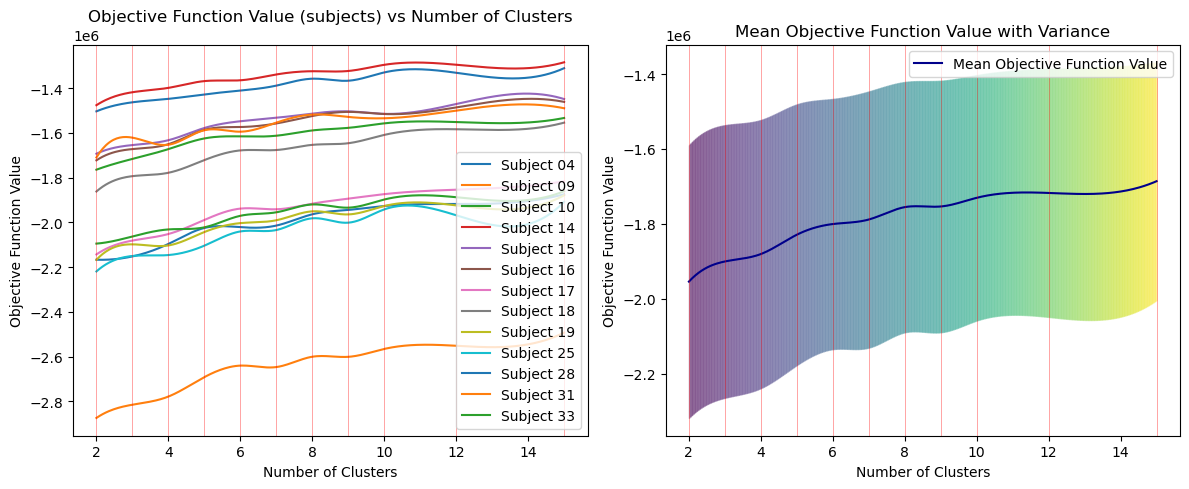

In [65]:
# Create a figure with (1, 2) subplot arrangement
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# list of list, inderste liste indholder obj_vals for hvert subjects - ydre liste er hvert cluster
obj_vals = [cluster_assignments_objfunc_cent_num[1][cluster]['sub_obj'] for cluster in cluster_numbers]
# Transpose the list of lists
obj_vals = list(map(list, zip(*obj_vals)))


for idx, subject in enumerate(valid_data_lib):
    # Interpolation for smoothing
    x_smooth = np.linspace(min(cluster_numbers), max(cluster_numbers), 300)  # 300 points for smooth curve
    spline = make_interp_spline(cluster_numbers, obj_vals[idx], k=3)
    smooth_obj_vals = spline(x_smooth)
        
    axes[0].plot(x_smooth, smooth_obj_vals, label=f'Subject {subject}')  # Plot the smoothed values

# Compute mean and variance across subjects for each number of clusters
obj_val_array = np.array(obj_vals)
mean_values = np.mean(obj_val_array, axis=0) 
variance_values = np.var(obj_val_array, axis=0)
std_dev = np.sqrt(variance_values)

# Interpolation for smoothing
x_smooth = np.linspace(min(cluster_numbers), max(cluster_numbers), 300)  # 300 points for smooth curve

# Create splines for mean and standard deviation
mean_spline = make_interp_spline(cluster_numbers, mean_values, k=3)
std_spline = make_interp_spline(cluster_numbers, std_dev, k=3)

# Evaluate splines
smooth_mean = mean_spline(x_smooth)
smooth_std = std_spline(x_smooth)

# Plot the smoothed mean and variance with gradient color
cmap = plt.get_cmap('viridis')

# Fill between for the smooth standard deviation
for i in range(len(x_smooth) - 1):
    axes[1].fill_between(x_smooth[i:i+2], 
                         smooth_mean[i:i+2] - smooth_std[i:i+2], 
                         smooth_mean[i:i+2] + smooth_std[i:i+2],
                         color=cmap(i / len(x_smooth)), 
                         alpha=0.3)

axes[1].plot(x_smooth, smooth_mean, label='Mean Objective Function Value', color='darkblue')

# Add thin vertical and slightly transparent red lines at each number of clusters
for ax in axes:
    for cluster in cluster_numbers:
        ax.axvline(x=cluster, color='red', linestyle='-', linewidth=0.5, alpha=0.5)

# Add labels and title for subplot 1
axes[0].set_xlabel('Number of Clusters')
axes[0].set_ylabel('Objective Function Value')
axes[0].set_title('Objective Function Value (subjects) vs Number of Clusters')
axes[0].legend()
axes[0].grid(False)

# Add labels and title for subplot 2
axes[1].set_xlabel('Number of Clusters')
axes[1].set_ylabel('Objective Function Value')
axes[1].set_title('Mean Objective Function Value with Variance')
axes[1].legend()
axes[1].grid(False)

plt.tight_layout()
plt.show()

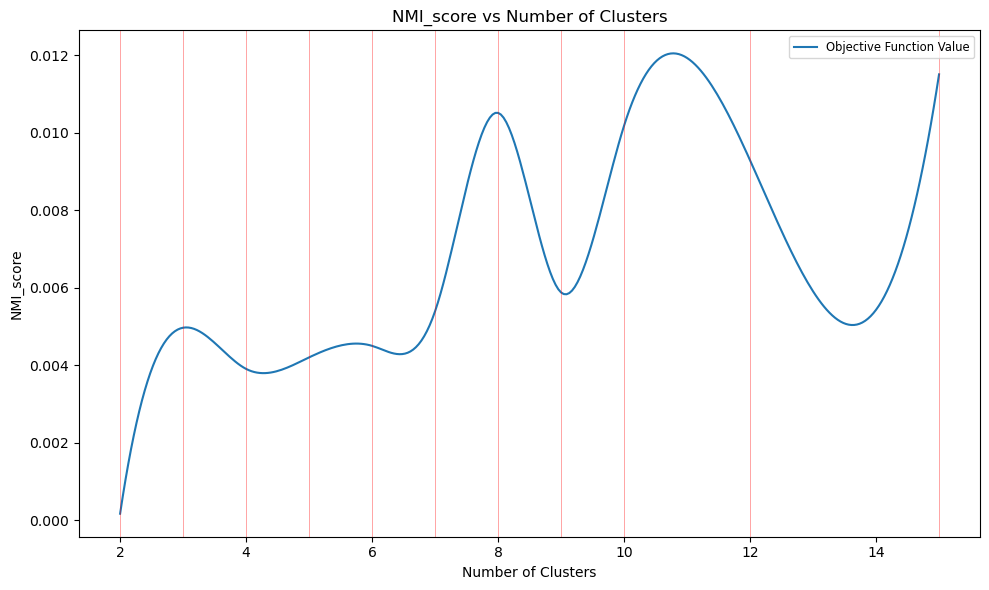

In [66]:
# Assuming NMI_scores and cluster_numbers are defined
# Define the cluster numbers and figure size
plt.figure(figsize=(10, 6))

# List to store objective function values for each cluster
NMI_scores_list = []

run = 1

# Collect the objective function values for each cluster
for cluster in cluster_numbers:
    NMI_scores_list.append(NMI_scores[run][cluster])

# Interpolation for smoothing
x_smooth = np.linspace(min(cluster_numbers), max(cluster_numbers), 300)  # 300 points for smooth curve
spline = make_interp_spline(cluster_numbers, NMI_scores_list, k=3)
smooth_obj_vals = spline(x_smooth)

# Plot the smoothed objective function values
plt.plot(x_smooth, smooth_obj_vals, label='Objective Function Value')

# Add thin vertical and slightly transparent red lines at each number of clusters
for cluster in cluster_numbers:
    plt.axvline(x=cluster, color='red', linestyle='-', linewidth=0.5, alpha=0.5)

# Add labels and title
plt.xlabel('Number of Clusters')
plt.ylabel('NMI_score')
plt.title('NMI_score vs Number of Clusters')
plt.grid(False)
plt.legend(loc='best', fontsize='small')
plt.tight_layout()
plt.show()

In [77]:
from collections import defaultdict, Counter

true_label_list = []
for subject in valid_data_lib:
    for number in valid_data_lib[subject]:
        true_label_list.append(all_data_matrices[subject][number])

flattened_true_labels = [label for sublist in true_label_list for label in sublist]


from collections import defaultdict

def count_labels_per_cluster(cluster_assignments):

    # Ensure that cluster_assignments and flattened_true_labels have the same length
    assert len(cluster_assignments) == len(flattened_true_labels), "The lengths of cluster_assignments and flattened_true_labels do not match."

    # Initialize a dictionary to store counts for each cluster
    cluster_counts = defaultdict(lambda: {'W': 0, '1': 0, '2': 0})

    # Iterate over the cluster assignments and true labels
    for cluster, label in zip(cluster_assignments, flattened_true_labels):
        label = str(label)  # Ensure the label is a string
        if label in cluster_counts[cluster]:
            cluster_counts[cluster][label] += 1

    # Display the counts in sorted order by cluster number
    for cluster in sorted(cluster_counts.keys()):
        counts = cluster_counts[cluster]
        print(f"Cluster {cluster}: W={counts['W']}, 1={counts['1']}, 2={counts['2']}")


In [88]:
count_labels_per_cluster(cluster_assignments_objfunc_cent_num[1][6]['part'])

Cluster 0: W=877, 1=1083, 2=875
Cluster 1: W=1669, 1=2513, 2=1625
Cluster 2: W=892, 1=1474, 2=611
Cluster 3: W=1362, 1=1742, 2=1466
Cluster 4: W=364, 1=620, 2=617
Cluster 5: W=1347, 1=2033, 2=1124


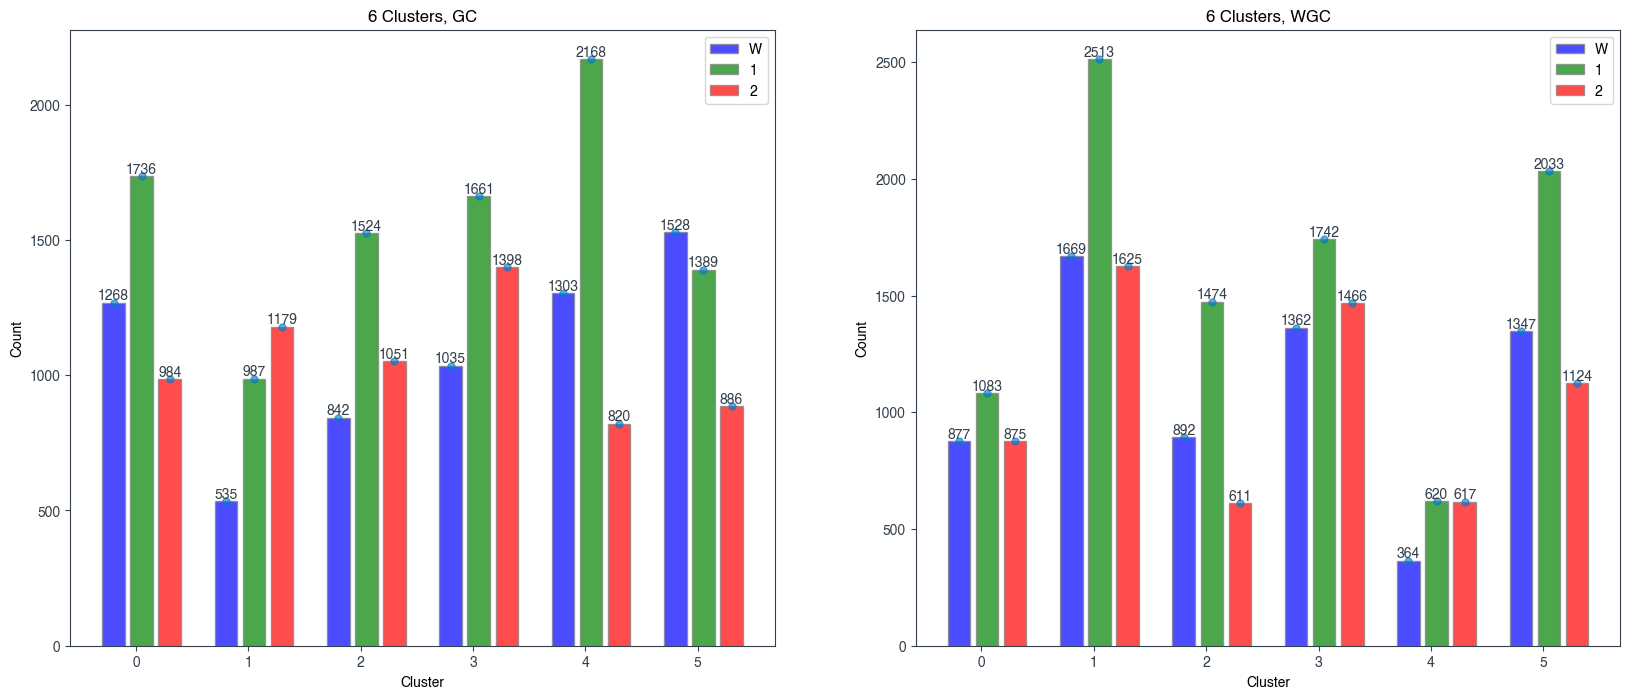

In [90]:
import matplotlib.pyplot as plt
import numpy as np

# Data for each cluster
cluster_data1 = {
    0: {'W': 1268, '1': 1736, '2': 984},
    1: {'W': 535, '1': 987, '2': 1179},
    2: {'W': 842, '1': 1524, '2': 1051},
    3: {'W': 1035, '1': 1661, '2': 1398},
    4: {'W': 1303, '1': 2168, '2': 820},
    5: {'W': 1528, '1': 1389, '2': 886}
}

cluster_data2 = {
    0: {'W': 877, '1': 1083, '2': 875},
    1: {'W': 1669, '1': 2513, '2': 1625},
    2: {'W': 892, '1': 1474, '2': 611},
    3: {'W': 1362, '1': 1742, '2': 1466},
    4: {'W': 364, '1': 620, '2': 617},
    5: {'W': 1347, '1': 2033, '2': 1124}
}

def plot_cluster_data(ax, cluster_data, title):
    # Preparing the data for plotting
    clusters = list(cluster_data.keys())
    W_counts = [cluster_data[cluster]['W'] for cluster in clusters]
    one_counts = [cluster_data[cluster]['1'] for cluster in clusters]
    two_counts = [cluster_data[cluster]['2'] for cluster in clusters]

    # Create a bar plot
    bar_width = 0.2  # Reduced width for thinner bars
    r1 = np.arange(len(clusters))
    r2 = [x + bar_width + 0.05 for x in r1]  # Adding small space between bars
    r3 = [x + bar_width + 0.05 for x in r2]

    bars1 = ax.bar(r1, W_counts, color='blue', width=bar_width, edgecolor='grey', alpha=0.7, label='W')
    bars2 = ax.bar(r2, one_counts, color='green', width=bar_width, edgecolor='grey', alpha=0.7, label='1')
    bars3 = ax.bar(r3, two_counts, color='red', width=bar_width, edgecolor='grey', alpha=0.7, label='2')

    # Adding labels and title
    ax.set_xlabel('Cluster', fontweight='bold')
    ax.set_ylabel('Count', fontweight='bold')
    ax.set_title(title)
    ax.set_xticks([r + bar_width for r in range(len(clusters))])
    ax.set_xticklabels(clusters)
    ax.legend()

    # Adding the actual counts on top of each bar
    def add_counts(bars):
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height}', ha='center', va='bottom', fontsize=10, color='#333F4B')
            # Add a small dot on top of each bar
            ax.plot(bar.get_x() + bar.get_width() / 2.0, height, "o", markersize=5, color='#007acc', alpha=0.6)

    add_counts(bars1)
    add_counts(bars2)
    add_counts(bars3)

# Styling configuration
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'
plt.rcParams['axes.edgecolor'] = '#333F4B'
plt.rcParams['axes.linewidth'] = 0.8
plt.rcParams['xtick.color'] = '#333F4B'
plt.rcParams['ytick.color'] = '#333F4B'

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot the two datasets side by side
plot_cluster_data(ax1, cluster_data1, '6 Clusters, GC')
plot_cluster_data(ax2, cluster_data2, '6 Clusters, WGC')

# Display the plot
plt.show()


In [69]:
import numpy as np
import nibabel as nib
import nilearn.plotting as plotting
import matplotlib.pyplot as plt
import hcp_utils as hcp
atlas_file = 'Schaefer2018_100Parcels_7Networks_order_Tian_Subcortex_S1.dlabel.nii'
img = nib.load(atlas_file)
X = img.get_fdata()
X.shape
for i in range(116):
    X[0][X[0]==i+1] = cluster_assignments_objfunc_cent_num[1][6]['C'][2][:,0][i]

plotting.view_surf(hcp.mesh.midthickness,hcp.cortex_data(X[0]),cmap='jet',symmetric_cmap=True,threshold=0.075)

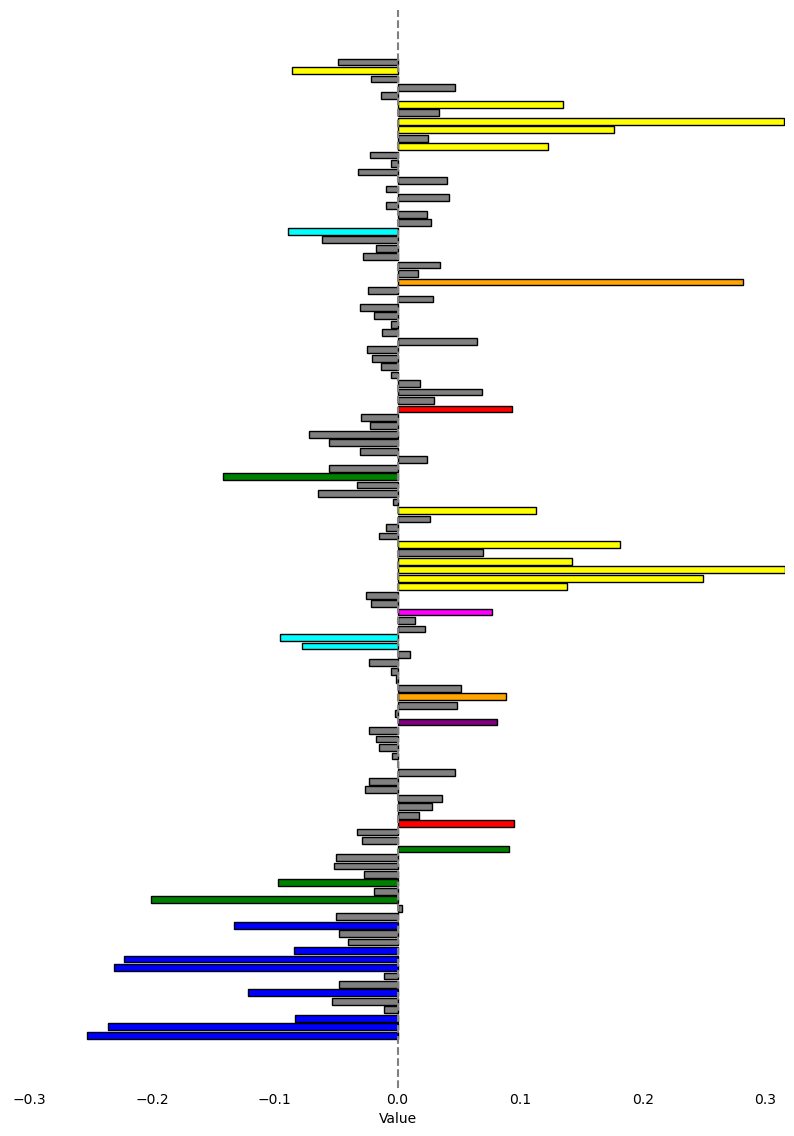

In [87]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import matplotlib.patches as mpatches

# Define the lists for each brain region
regions = {
    1: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
    2: [17, 18, 19, 20, 21, 22, 23, 24, 25, 67, 68, 69, 70, 71, 72, 73, 74],
    3: [26, 27, 28, 29, 30, 31, 75, 76, 77, 78, 79, 80, 81, 82],
    4: [32, 33, 34, 35, 36, 37, 38, 39, 83, 84, 85, 86, 87, 88, 89],
    5: [40, 41, 42, 43, 44, 45, 46, 90, 91, 92, 93, 94],
    6: [47, 48, 49, 95, 96],
    7: [50, 51, 52, 53, 97, 98, 99, 100, 101, 102, 103, 104, 105],
    8: [54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116]
}

labels = ['Subcortex', 'Visuals', 'SomatoMotor', 'Dorsal_attention', 'Salience_Ventral_attention', 'Limbic', 'Control', 'Default']

# Create a color map for the regions
color_map = {
    1: 'blue',
    2: 'green',
    3: 'red',
    4: 'purple',
    5: 'orange',
    6: 'cyan',
    7: 'magenta',
    8: 'yellow'
}

# Generate indices for the y-axis
indices = np.arange(len(cluster_assignments_objfunc_cent_num[1][6]['C'][4][:, 0]))

# Get the data for the bar plot
data = cluster_assignments_objfunc_cent_num[1][6]['C'][4][:, 0]

# Assign colors based on the regions and threshold
colors = ['grey' if abs(value) < 0.075 else 'black' for value in data]  # Default to grey for values under threshold
for region, indices_list in regions.items():
    for idx in indices_list:
        if idx - 1 < len(colors) and abs(data[idx - 1]) >= 0.075:
            colors[idx - 1] = color_map[region]

# Create a figure and a single subplot
fig, ax = plt.subplots(figsize=(10, 14))

# Create the horizontal bar plot
ax.barh(indices, data, color=colors, edgecolor='black')

# Add a vertical line at 0 to center the plot
ax.axvline(x=0, color='grey', linestyle='--')

# Calculate the limits for the x-axis to ensure symmetry around 0
max_abs_value = max(abs(data))
ax.set_xlim(-max_abs_value, max_abs_value)

# Set labels and title
ax.set_xlabel('Value')
#ax.set_title('First component of centroid')

# Remove y-axis ticks and labels
ax.set_yticks([])
ax.set_yticklabels([])

for spine in ax.spines.values():
    spine.set_visible(False)

ax.tick_params(axis='x', which='both', length=0)

# Create custom legend
# patches = [mpatches.Patch(color=color_map[i], label=labels[i-1]) for i in color_map]

#plt.legend(handles=patches, loc='upper right', bbox_to_anchor=(0.3, 1))

# Show the plot
plt.show()
